In [1]:
%matplotlib inline

## Variograms Example - Ground Elevation Data for Dresden

### Import Packages

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

### Load Data from `.csv`-file

In [3]:
df = pd.read_csv("Data_Dresden.csv", sep=";")
print(df.shape)
df.head()

(35, 5)


,Ort,Nummer,Rechtswert [m],Hochwert [m],Hoehe [m ue. NN]
0,Altmarkt,1,5411525,5656080,114
1,Zwinger,2,5411250,5656485,110
2,Hbf,3,5411185,5655012,115
3,Chemiebau,4,5410975,5653670,143
4,Wasaplatz,5,5413006,5653677,123


### Cumulative Histogram

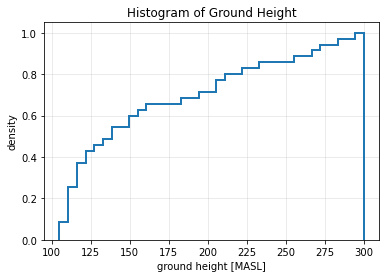

In [4]:
ax = df.iloc[:, -1].hist(cumulative=True, density=True, histtype="step", lw=2, bins=df.shape[0])
ax.set_xlabel("ground height [MASL]")
ax.set_ylabel("density")
ax.set_title("Histogram of Ground Height")
ax.grid(True, alpha=0.3)

### Calculate Distances

In [5]:
# arrays to store distance values in
distances = []
hdiffs = []

# iterate through all points (outter loop)
for point1 in zip(df.iloc[:, 2], df.iloc[:, 3], df.iloc[:, 4]):
    dist_from_point1 = []
    hdiff_from_point1 = []
    # iterate through all points (inner loop)
    for point2 in zip(df.iloc[:, 2], df.iloc[:, 3], df.iloc[:, 4]):
        
        # calculate dx
        dx = point2[0] - point1[0]
        
        # calculate dy
        dy = point2[1] - point1[1]
        
        # calculate distance
        dist = ((dx ** 2) + (dy ** 2)) ** 0.5
        
        # calculate hdiff
        hdiff = (point1[2] - point2[2]) ** 2
        
        # append results to dist_from_point1 and hdiff_from_point1
        dist_from_point1.append(dist)
        hdiff_from_point1.append(hdiff)
        
    
    # append all distances from one point to all
    # other points to the distances array
    distances.append(dist_from_point1)
    hdiffs.append(hdiff_from_point1)
        

### Visual Representation of Distances and Ground Height Differences

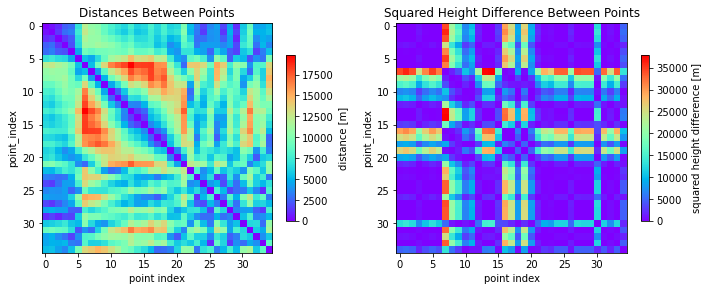

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))

im1 = ax[0].imshow(distances, cmap="rainbow")
cbar1 = plt.colorbar(im1, shrink=0.3, ax=ax[0])
cbar1.set_label("distance [m]")
ax[0].set_title("Distances Between Points")
ax[0].set_xlabel("point index")
ax[0].set_ylabel("point_index")

im2 = ax[1].imshow(hdiffs, cmap="rainbow")
cbar2 = plt.colorbar(im2, shrink=0.3, ax=ax[1])
cbar2.set_label("squared height difference [m]")
ax[1].set_title("Squared Height Difference Between Points")
ax[1].set_xlabel("point index")
ax[1].set_ylabel("point_index")

plt.tight_layout()

### Sort Distances

In [7]:
# array to store distances and other information
preprocessed_data = []

for row in range(0, len(distances) - 1):
    for col in range(row + 1, len(distances)):
        
        # information = [point1, point2, dist, hdiff]
        information = [row, col, distances[row][col], hdiffs[row][col]]
        
        preprocessed_data.append(information)
        
# put data to DataFrame
df_preprocessed = pd.DataFrame(data=preprocessed_data, columns=["point1", "point2", "distance", "hdiff"])

# sort data according to distance
df_sorted = df_preprocessed.sort_values(by=["distance"])
df_sorted.index = [i for i in range(len(df_sorted))]

In [8]:
df_sorted.head()

,point1,point2,distance,hdiff
0,0,1,489.540601,16
1,2,29,993.227064,1
2,25,33,1090.875337,1
3,0,2,1120.813990,1
4,0,29,1182.642803,4


### Function to Calculate Empirical Variogram Values Based on Number of Classes / Number of Values in each Class

In [9]:
def variogram(data, class_col, var_col, nvals):
    # data : pd.DataFrame containing relevant and sorted data, pd.DataFrame
    # class_col: column to use to calculate class centers, int
    # var_col : column to use for the variogram data, int
    # nvals : number of values to consider in each class, int
    
    nclasses = math.ceil(len(data) / nvals)
    
    # split array
    data_split = np.array_split(data, nclasses)
    
    # get center of class and variogram values
    ccenters = []
    var_values = []
    
    for c in data_split:
        ccenter = (c.iloc[-1, class_col] + c.iloc[0, class_col]) / 2
        var_value = (c.iloc[:, var_col].sum() / (2 * nvals))
        ccenters.append(ccenter)
        var_values.append(var_value)
        
    return ccenters, var_values

### Defining Functions to Calculate Residuals Between Empirical and Theoretical Variogram Values

In [10]:
def exp_var(x, class_centers, y_true):
    # x : array [nugget, variance, correlation_length] of parameters, array
    # class_centers : class centers to calculate variogram at, array
    # y_true : observed variogram values (empirical variogram), array
    
    # NOTES: this function takes class centers and observed variogram values
    # and returns an array of residuals between the theoretical function and
    # observed values
    
    exp = [(x[0] + (x[1] - x[0]) * (1 - np.exp(- i / x[2]))) for i in class_centers]
    
    return np.array(np.array(exp) - np.array(y_true))

def gauss_var(x, class_centers, y_true):
    # x : array [nugget, variance, correlation_length] of parameters, array
    # class_centers : class centers to calculate variogram at, array
    # y_true : observed variogram values (empirical variogram), array
    
    # NOTES: this function takes class centers and observed variogram values
    # and returns an array of residuals between the theoretical function and
    # observed values
    
    gauss = [(x[0] + (x[1] - x[0]) * (1 - np.exp(-1 * ((i / x[2]) ** 2)))) for i in class_centers]
    
    return np.array(np.array(gauss) - np.array(y_true))

def spherical_var(x, class_centers, y_true):
    # x : array [nugget, variance, correlation_length] of parameters, array
    # class_centers : class centers to calculate variogram at, array
    # y_true : observed variogram values (empirical variogram), array
    
    # NOTES: this function takes class centers and observed variogram values
    # and returns an array of residuals between the theoretical function and
    # observed values
    
    spherical = [(x[0] + (x[1] - x[0]) * 0.5 * i / x[2] * (3 - (i / x[2]) ** 2)) if i < x[2] else x[1] for i in class_centers]
    
    return np.array(np.array(spherical) - np.array(y_true))

def power_var(x, class_centers, y_true):
    # x : array [nugget, slope, power] of parameters, array
    # class_centers : class centers to calculate variogram at, array
    # y_true : observed variogram values (empirical variogram), array
    
    # NOTES: this function takes class centers and observed variogram values
    # and returns an array of residuals between the theoretical function and
    # observed values
    
    power = [(x[0] + (x[1] - x[0]) * i ** x[2]) for i in class_centers]
    
    return np.array(np.array(power) - np.array(y_true))

### Fitting and Plotting Empirical and Fitted Theoretical Variograms

In [17]:
def plot_variograms(class_centers, variogram_values):
    # class_centers : class centers, array
    # variogram_values : variogram values, array
    
    # x-values for theoretical variograms
    xs = np.arange(0, max(class_centers), 100)
    
    """ exponential variogram """
    # scipy least squares optimization for exp
    exp_x0 = np.array([0, 3000, 3000])
    result_exp = least_squares(
        exp_var,
        exp_x0,
        kwargs={"class_centers": class_centers, "y_true": variogram_values},
        bounds=([0, 0, 0], [1000, 10000, 10000])
    )
    
    # fitted exponential variogram    
    exp_fit = [(result_exp.x[0] + (result_exp.x[1] - result_exp.x[0]) * (1 - np.exp(- i / result_exp.x[2]))) for i in xs]
    
    """ gaussian variogram """
    # scipy least squares optimization for gauss
    gauss_x0 = np.array([0, 3000, 3000])
    result_gauss = least_squares(
        gauss_var,
        gauss_x0,
        kwargs={"class_centers": class_centers, "y_true": variogram_values},
        bounds=([0, 0, 0], [1000, 10000, 10000])
    )
    
    # fitted gauss variogram    
    gauss_fit = [(result_gauss.x[0] + (result_gauss.x[1] - result_gauss.x[0]) * (1 - np.exp(-1 * ((i / result_gauss.x[2]) ** 2)))) for i in xs]
    
    """ shperical variogram """
    # scipy least squares optimization for spherical
    spherical_x0 = np.array([0, 3000, 3000])
    result_spherical = least_squares(
        spherical_var,
        spherical_x0,
        kwargs={"class_centers": class_centers, "y_true": variogram_values},
        bounds=([0, 0, 0], [1000, 10000, 10000])
    )
    
    # fitted spherical variogram    
    spherical_fit = [(result_spherical.x[0] + (result_spherical.x[1] - result_spherical.x[0]) * 0.5 * i / result_spherical.x[2] * \
                      (3 - (i / result_spherical.x[2]) ** 2)) if i < result_spherical.x[2] else result_spherical.x[1] for i in xs]
    
    """ power variogram """
    # scipy least squares optimization for power
    power_x0 = np.array([0, 1, 1])
    result_power = least_squares(
        power_var,
        power_x0,
        kwargs={"class_centers": class_centers, "y_true": variogram_values},
        bounds=([0, 0, 0], [1000, 10000, 10000])
    )
    
    # fitted power variogram    
    power_fit = [(result_power.x[0] + (result_power.x[1] - result_power.x[0]) * i ** result_power.x[2]) for i in xs]
    
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(class_centers, variogram_values, marker="x", c="black", label="empirical variogram")
    
    ax.plot(xs, exp_fit, label="Exponential", c="red")
    ax.plot(xs, gauss_fit, label="Gaussian", c="deepskyblue")
    ax.plot(xs, spherical_fit, label="Spherical", c="limegreen")
    ax.plot(xs, power_fit, label="Power", c="purple")
    
    # print out the fitted parameters
    ax.text(1.05, 0.9, "Exponential: \n nugget = %1.2f \n variance = %1.2f \n corr. length = %1.2f" \
            %(result_exp.x[0], result_exp.x[1], result_exp.x[2]), transform=ax.transAxes)
    
    ax.text(1.05, 0.75, "Gaussian: \n nugget = %1.2f \n variance = %1.2f \n corr. length = %1.2f" \
            %(result_gauss.x[0], result_gauss.x[1], result_gauss.x[2]), transform=ax.transAxes)
    
    ax.text(1.05, 0.6, "Spherical: \n nugget = %1.2f \n variance = %1.2f \n corr. length = %1.2f" \
            %(result_spherical.x[0], result_spherical.x[1], result_spherical.x[2]), transform=ax.transAxes)
    
    ax.text(1.05, 0.45, "Power: \n nugget = %1.2f \n slope = %1.2f \n power = %1.2f" \
            %(result_power.x[0], result_power.x[1], result_power.x[2]), transform=ax.transAxes)
    
    ax.legend(loc="best")
    ax.set_xlabel("distance [m]")
    ax.set_ylabel("variogram $[m^2]$")
    ax.set_title("Empirical and Fitted Theoretical Variograms")
    ax.grid(True, alpha=0.4, zorder=0)
    
    return ax

### Creating Empirical Variogram Values and Fit Theoretical Variograms

- try different number of values in the classes
- try different initial conditions for theoretical variograms
- try different parameter bounds for theoretical variograms

<AxesSubplot:title={'center':'Empirical and Fitted Theoretical Variograms'}, xlabel='distance [m]', ylabel='variogram $[m^2]$'>

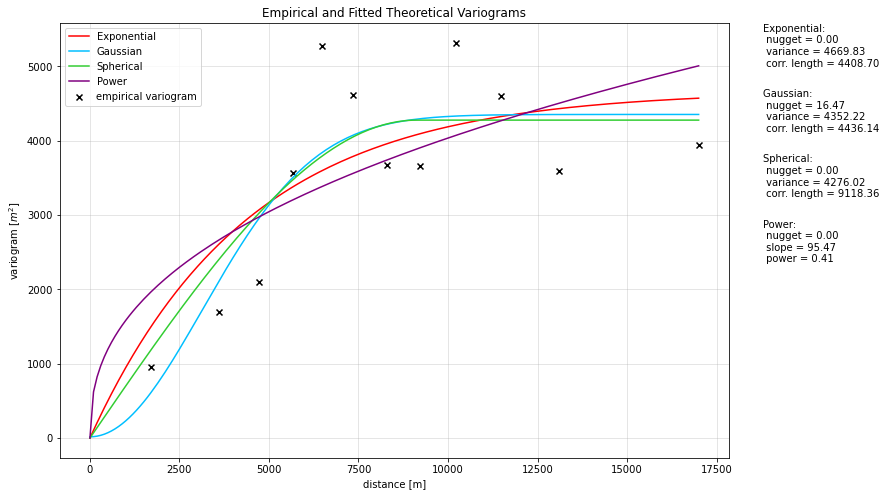

In [18]:
ccenters, var_values = variogram(data=df_sorted, class_col=2, var_col=3, nvals=50)
plot_variograms(class_centers=ccenters, variogram_values=var_values)